# Лабораторная работа 6. 

# Cегментация изображений


В этой работе рассматриваются методы сегментации изображений.

Цель лабораторной работы: научиться применять методы сегментации изображений.

#
Настроим Jupyter на отображение полного интерактивного вывода:

#
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

### Дополнительные библиотеки

- https://scikit-learn.org/stable/
- conda install -c anaconda scikit-learn

- https://scikit-image.org/
- conda install -c anaconda scikit-image

In [1]:
import sys
sys.path.append('../')
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import data
from scipy import ndimage
import matplotlib.pyplot as plt
from utility import segmentation_utils


### Загрузим изображение

In [2]:
image = cv.imread('dress.jpg')
image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

#### Сдвиг среднего (Mean shift)
  
 https://ru.wikipedia.org/wiki/%D0%A1%D0%B4%D0%B2%D0%B8%D0%B3_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B3%D0%BE_%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D1%8F
 
 Метод основан на непараметрической оценке плотности распределения признаков пикселей (яркость, градиент и т.п.). 
 Для непараметрической оценки применяются ядерные функции.
 Алгоритм сдвига среднего ищет локальные максимуму плотности распределения в n-мерном пространстве признаков.
  

    1 Задаем параметры окна (размер и местоположение).

    2 Вычисляем среднее значение данных в окне.

    3 Смещаем окно в координаты среднего значения.

    4 Повторяем до нахождения максимума, возвращаемся в п.1.

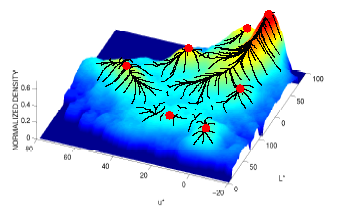

  Алгоритм не учитывает пространственную близость пикселей, но не требует задания количества кластеров.
  
  ### Алгоритм вычисляется достаточно долго...


Number of segments:  12


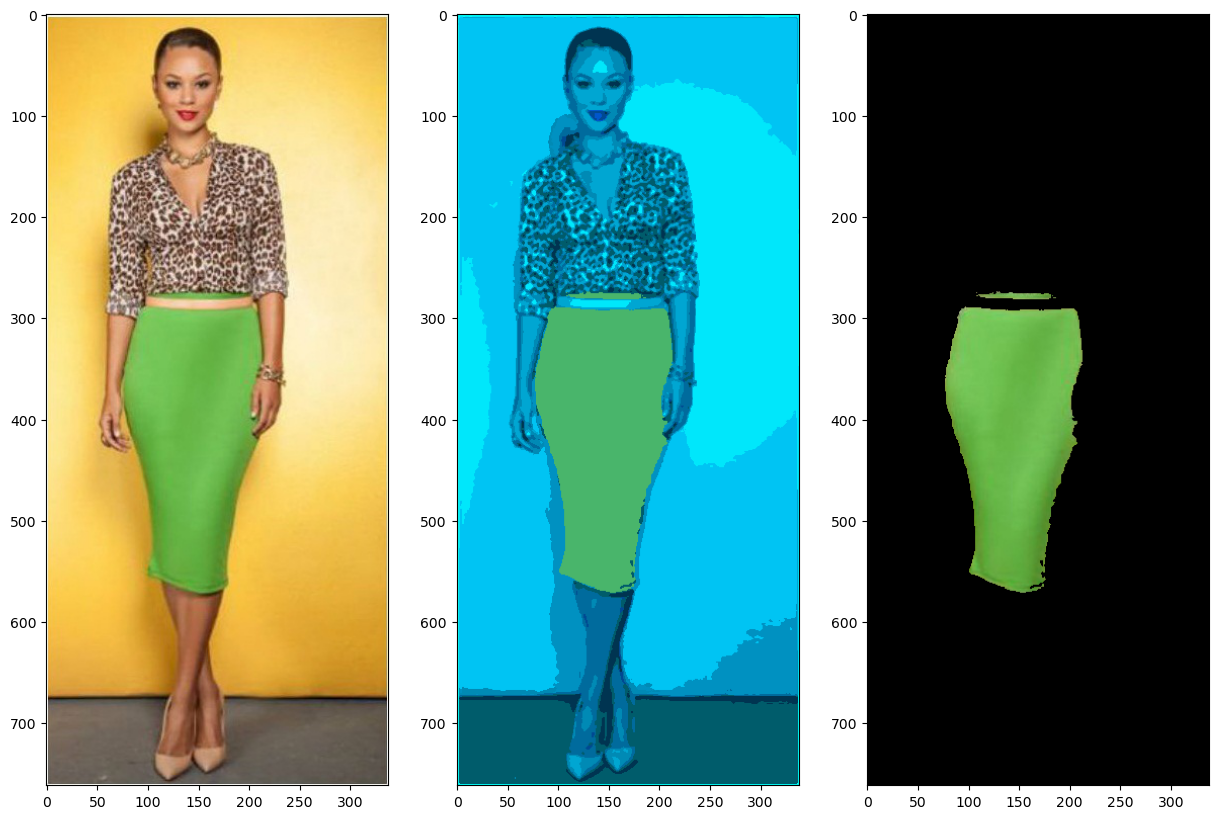

In [6]:
## Методы кластеризации. Сдвиг среднего (Mean shift)
# Сглаживаем чтобы уменьшить шум
blur_image = cv.medianBlur(image, 3)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_

# получим количество сегментов
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((image.shape))
# Маской скроем один из сегментов
mask1 = mean_shift_image[:,:,0]
mask1[mask1!=73] = 0
mean_shift_with_mask_image = cv.bitwise_and(image, image, mask=mask1)
# Построим изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(mean_shift_with_mask_image, cv.COLOR_BGR2RGB))
plt.show()